In [1]:
# Computing id: nb7ug
# Name: Niharika Reddy

# Import necessary libraries

In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
import pyspark

# Creating the spark context

In [3]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

# Importing dataset from s3 bucket

In [4]:
bucket='odl-spark19spds6003-001'
data_key = 'nb7ug/heart.csv' # Where the file is within the bucket
data_location = 's3://{}/{}'.format(bucket, data_key)
dataset = pd.read_csv(data_location)

In [5]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Converting dataframe to parquet

In [7]:
df = sqlc.createDataFrame(dataset)
parquetPath = '/home/ec2-user/SageMaker/Spark19SpDS6003-001/nb7ug/parquet-data-heart'
df.write.parquet(parquetPath)

# Write to spark dataframe from parquet


In [8]:
df = sqlc.read.parquet(parquetPath)

In [9]:
display(df)

DataFrame[age: bigint, sex: bigint, cp: bigint, trestbps: bigint, chol: bigint, fbs: bigint, restecg: bigint, thalach: bigint, exang: bigint, oldpeak: double, slope: bigint, ca: bigint, thal: bigint, target: bigint]

In [10]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- cp: long (nullable = true)
 |-- trestbps: long (nullable = true)
 |-- chol: long (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: long (nullable = true)
 |-- thalach: long (nullable = true)
 |-- exang: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: long (nullable = true)
 |-- ca: long (nullable = true)
 |-- thal: long (nullable = true)
 |-- target: long (nullable = true)



# Visualising the proportion of target variable categories

([<matplotlib.axis.XTick at 0x7f7bd34d06a0>,
 <a list of 2 Text xticklabel objects>)

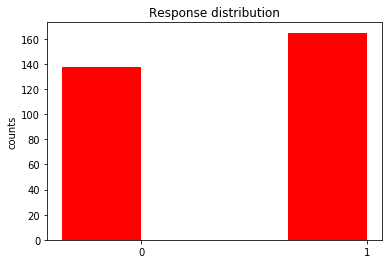

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
 
responses = df.groupBy('target').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Response distribution')
plt.xticks(ind + width/2., categories)

# MACHINE LEARNING

### Preparing a well defined dataset for machine learning

In [16]:
# Data pre-processing before building a model
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler


assembler_features = VectorAssembler(inputCols=['age','sex','cp','trestbps','chol','fbs','restecg', 'thalach','exang','oldpeak','slope','ca','thal','target'], outputCol="features")
stages = [assembler_features]
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
stages += [label_stringIdx]
pipeline = Pipeline(stages=stages)

In [21]:
#Split into training and validation sets
allData = pipeline.fit(df).transform(df)
allData.cache()
trainingData, testData = allData.randomSplit([0.8,0.2], seed=0) # need to ensure same split for each time
print("Distribution of Positives and Negatives in trainingData is: ", trainingData.groupBy("label").count().take(2))


Distribution of Positives and Negatives in trainingData is:  [Row(label=0.0, count=133), Row(label=1.0, count=117)]


## Train and prediction

In [24]:
#Using random forest with no. of trees = 5
from pyspark.ml.classification import RandomForestClassifier as RF

rf = RF(labelCol='label', featuresCol='features',numTrees=5)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

## Model Evaluation(AUC)

In [30]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=5): ", metrics.areaUnderROC)


The ROC score is (@numTrees=5):  1.0


# Visualizing the ROC Curve

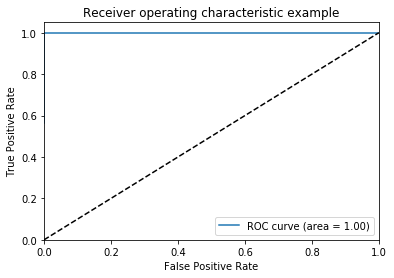

In [31]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()